In [23]:
# 清空内核状态
%reset -f

In [24]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
setup_seed(123456)

In [25]:
#要设置的参数
Ex=0#E也要放小e6倍，这里是0就不放了
Ey=0
Ez=0#托卡马克里面没电场
B0=5#磁轴中心的磁感应强度为5T
q=2.5#安全因子，注意，不是电荷
R0=6.2#托卡马克大半径6.2m
q_over_m = 4.822452834e1  # 电荷与质量之比

#单位问题：跑太大的数，程序吃不消，得归一化。几个大数，q_over_m = 4.8e7，vx0vy0 1e6 5e6，interval 4.1473e-9，要动
#程序中，要让轨迹相对形状不变，又因为B和位置有关，所以轨迹数值也不能变
#a=q/m（E+vB），x=vt+0.5at^2
#让位移x=vt+0.5at^2不变，让interval扩大e6倍，让v缩小e6倍(让v0和x0在同一量级，这样好训练)，让q_over_m缩小e6倍，E也要放小e6倍，这样a放小e12个
def Bx(x,y,z):
    return B0/q*(-q*R0*y+z*x)/(x**2+y**2)
def By(x,y,z):
    return B0/q*(q*R0*x+z*y)/(x**2+y**2)
def Bz(x,y,z):
    return B0/q*(-1+R0/(x**2+y**2)**0.5)
    

target_x0=torch.tensor([-4.71551682007010])#t=8000，第1个数据
target_y0=torch.tensor([4.77705978317206])
target_z0=torch.tensor([-0.821027867281611])


# target_x2=torch.tensor([7.18152837066236])#t=200interval对应的点，第201个数据
# target_y2=torch.tensor([0.412830942088255])
# target_z2=torch.tensor([-0.0220679629391214])

target_x2=torch.tensor([2.86074511407999])#t=4000interval对应的点，第201个数据
target_y2=torch.tensor([6.46992054388723])
target_z2=torch.tensor([-0.472978824469992])

interval=4.147267104135095e-4#根据学长给的数据取值,e-3是小圈的1/2π,e-4就是小圈的60分之一，更精确
#总运动时间是n*interval
learning_rate=2e-3

stop_condition = 5e-4#停止训练的loss值要求


#设置初始权重
lamda1=1#lpde权重
lamda2=400#lE权重
lamda3=600#l0权重




In [26]:
n=50#训练中的t共n个时间点,注意画三维图的点不建议超过200个，容易炸内核
n_all=10000#总覆盖时间点数，绘图用
jump=0#单位是interval
n_epoch=10#每几次epoch就计数

n_test=50#在n_all范围内，等距取多少个test点
new_prefix = "8.6.changsui"  # 新的文件名前缀

In [27]:
#Neural Network
#t作为输入，x,y,z作为输出，中间三个隐藏层
#MLP是最基础的全连接神经网络

class SinActivation(torch.nn.Module):
    def __init__(self):
        super(SinActivation, self).__init__()
        self.a = nn.Parameter(torch.tensor(0.1))  # 将a设置为可学习的参数

    def forward(self, x):
        return torch.sin(self.a *10* x)

class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1,128),#0层
            SinActivation(),#1层
            torch.nn.Linear(128,128),#2层
            SinActivation(),#3
            torch.nn.Linear(128,128),#4
            SinActivation(),#5
            torch.nn.Linear(128,128),#6
            SinActivation(),#7
            torch.nn.Linear(128,3),#8
        )
         # 对每个线性层进行Glorot初始化
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
    def forward(self,x):
        return self.net(x)
    
    
u = MLP()  # 网络名称



In [28]:
# import torch
# #from ceshi_Copy1 import MLP  # 导入你的模型类定义

# # 创建模型实例
# # u = MyModel()

# # 加载模型参数
# u.load_state_dict(torch.load('3.1.1保存.pth'))

# # 设置模型为评估模式（如果只是进行推理）
# # u.eval()

In [29]:


#下面是求导
def gradients(x,t,order=1):
    if order == 1:
        return torch.autograd.grad(x,t,grad_outputs=torch.ones_like(x),#用于计算某个标量相对于一组输入张量的梯度
                                  create_graph = True,
                                  only_inputs=True,)[0]#create_graph： 这是一个布尔值，如果设置为 True，则创建一个用于计算更高阶梯度的计算图。
                                                    #这对于执行高阶梯度的操作是有用的。在训练深度学习模型时，可能需要计算模型参数的二阶梯度。
    else:
        return gradients(gradients(x,t),t,order = order-1)#二阶及以上导

In [30]:


#损失函数
#LOSS
loss = torch.nn.MSELoss()
t0=torch.tensor([4000*interval]).requires_grad_(True)
target_vx0=gradients(u(t0)[0],t0,1)
target_vy0=gradients(u(t0)[1],t0,1)
target_vz0=gradients(u(t0)[2],t0,1)
with torch.no_grad():
    tensortarget = (target_vx0**2+target_vy0**2+target_vz0**2)**0.5
    target_initial = tensortarget.repeat(n+1).view(-1, 1)#保能量项用的

def funcmiu(x,y,z,vx,vy,vz):
    miu=(vx**2+vy**2+vz**2)/(Bx(x,y,z)**2+By(x,y,z)**2+Bz(x,y,z)**2)**0.5-(vx*Bx(x,y,z)+vy*By(x,y,z)+vz*Bz(x,y,z))**2/(Bx(x,y,z)**2+By(x,y,z)**2+Bz(x,y,z)**2)**1.5
    return miu


def LOSS(u):
    
    samples = torch.arange(jump*interval, (n_all+1+jump)*interval, step=int(n_all/n)*interval)+torch.rand(n+1) * interval*int(n_all/n)*1   #random jitter to samples 10%#实际上n+1个点
    t = samples.view(-1, 1).requires_grad_(True)
    x = u(t)[:, 0].view(-1, 1)
    y = u(t)[:, 1].view(-1, 1)
    z = u(t)[:, 2].view(-1, 1)
    vx = gradients(x, t, 1)
    vy = gradients(y, t, 1)
    vz = gradients(z, t, 1)

    lpde1 = loss(gradients(vx, t, 1), q_over_m*(Ex + vy * Bz(x,y,z) - vz * By(x,y,z)))
    lpde2 = loss(gradients(vy, t, 1), q_over_m*(Ey + vz * Bx(x,y,z) - vx * Bz(x,y,z)))
    lpde3 = loss(gradients(vz, t, 1), q_over_m*(Ez + vx * By(x,y,z) - vy * Bx(x,y,z)))

    lE = loss((vx**2+vy**2+vz**2)**0.5,target_initial)
    miu=funcmiu(x,y,z,vx,vy,vz)
    lpde = lpde1 + lpde2 + lpde3 

    

    return lpde,lE


In [31]:
opt = torch.optim.Adam(u.parameters(), lr=learning_rate)
def funcweight(lpde):
    lpde.backward(retain_graph=True)#初态只对第0层的weight的梯度才全是0，其他情况都有梯度
    # 获取网络的参数列表
    gradientlw0 = u.net[0].weight.grad.clone()
    gradientlb0 = u.net[0].bias.grad.clone()
    gradientlw2 = u.net[2].weight.grad.clone()
    gradientlb2 = u.net[2].bias.grad.clone()
    gradientlw4 = u.net[4].weight.grad.clone()
    gradientlb4 = u.net[4].bias.grad.clone()
    gradientlw6 = u.net[6].weight.grad.clone()
    gradientlb6 = u.net[6].bias.grad.clone()
    gradientlw8 = u.net[8].weight.grad.clone()
    gradientlb8 = u.net[8].bias.grad.clone()
    opt.zero_grad()
    tensors_l = [gradientlw0,gradientlb0,gradientlw2,gradientlb2,gradientlw4,gradientlb4,gradientlw6,gradientlb6,
                gradientlw8,gradientlb8]
    squared_sums = [torch.sum(tensor ** 2) for tensor in tensors_l]
    # 将所有平方和相加
    total_squared_sum = sum(squared_sums)
    l2_norm_gradient_l=(total_squared_sum.item())**0.5
    return l2_norm_gradient_l

In [32]:
# 加载文本文件
xdata = np.loadtxt('通行x_real.txt')
# 从第四个数据开始，每隔10个数据读取一个，共读取50个数据
xselected_data = xdata[jump::int(n_all/n_test)][:(n_test+1)]
# 将所选数据转换为PyTorch张量
x_real = torch.tensor(xselected_data, dtype=torch.float32).view(-1,1)

ydata = np.loadtxt('通行y_real.txt')
yselected_data = ydata[jump::int(n_all/n_test)][:(n_test+1)]
y_real = torch.tensor(yselected_data, dtype=torch.float32).view(-1,1)

zdata = np.loadtxt('通行z_real.txt')
zselected_data = zdata[jump::int(n_all/n_test)][:(n_test+1)]
z_real = torch.tensor(zselected_data, dtype=torch.float32).view(-1,1)



#全500点，用于后续绘图
x_plt=xdata[jump:(n_all+1+jump):1]
y_plt=ydata[jump:(n_all+1+jump):1]
z_plt=zdata[jump:(n_all+1+jump):1]
x_real_plt=torch.tensor(x_plt, dtype=torch.float32).view(-1,1)#真实值的0~500点，
y_real_plt=torch.tensor(y_plt, dtype=torch.float32).view(-1,1)
z_real_plt=torch.tensor(z_plt, dtype=torch.float32).view(-1,1)
# vxdata = (np.loadtxt('通行vx_real.txt'))*1e-6
# vydata = (np.loadtxt('通行vy_real.txt'))*1e-6
# vzdata = (np.loadtxt('通行vz_real.txt'))*1e-6
# vx_real_plt=torch.tensor(vxdata[jump:(n_all+1+jump):1], dtype=torch.float32).view(-1,1)
# vy_real_plt=torch.tensor(vydata[jump:(n_all+1+jump):1], dtype=torch.float32).view(-1,1)
# vz_real_plt=torch.tensor(vzdata[jump:(n_all+1+jump):1], dtype=torch.float32).view(-1,1)
xdata=[]
ydata=[]
zdata=[]
# vxdata=[]
# vydata=[]
# vzdata=[]#清空这二百四十万个数据

#x_real：用于训练过程神经网络输出值与真实值对比，3，13,23…493共50个时刻点，对应t_test
#x_real_plt：用于绘制真实图，0~500全点


In [33]:
#训练过程中记录的量
loss_list=[]#总损失，带权重
lpde_list=[]#方程项损失
l0_list=[]#初态损失
lE_list=[]#能量项损失loss，也是与真实能量做对比diff
E_list=[]
lamda1_list=[]#方程项权重，把保能量保磁矩也放在这一项
lamda2_list=[]#能量项权重
lamda3_list=[]#初态权重
l_withoutweight_list=[]#总损失，不带权重
time_list=[]#训练时间记录
loss_test_list=[]#部分时刻点，输出位置与真实位置误差向量的模平方，即位置与真实值的误差
lossmean_test_list=[]#部分时刻点，输出位置与真实位置误差的算术平均值，(sigma（xn+yn+zn）-sigma(xc+yc+zc))/n ,证明轨迹可以视为导心
miu_train_list=[]


In [34]:
import time
start_time = time.time()#计时
epochs = 4000  #训练次数
opt = torch.optim.Adam(u.parameters(), lr=learning_rate)

for i in range(epochs):
    opt.zero_grad()
    
    lpde=LOSS(u)[0]
    lE=LOSS(u)[1]
    l00=(u(torch.tensor([8000*interval]))[0] - target_x0)**2
    l01=(u(torch.tensor([8000*interval]))[1] - target_y0)**2
    l02=(u(torch.tensor([8000*interval]))[2] - target_z0)**2
    
    l20=(u(torch.tensor([4000*interval]))[0] - target_x2)**2
    l21=(u(torch.tensor([4000*interval]))[1] - target_y2)**2
    l22=(u(torch.tensor([4000*interval]))[2] - target_z2)**2
   
   
    l0=l00+l01+l02+l20+l21+l22
    
    if (i+1)%10==0:
       
        target_vx0=gradients(u(t0)[0],t0,1)
        target_vy0=gradients(u(t0)[1],t0,1)
        target_vz0=gradients(u(t0)[2],t0,1)
        with torch.no_grad():
            tensortarget = (target_vx0**2+target_vy0**2+target_vz0**2)**0.5
            target_initial = tensortarget.repeat(n+1).view(-1, 1)#保能量项用的

  
    if (i+1)%1000== 0:
        gradient_lpde=funcweight(lpde)
        gradient_lE=funcweight(lE)
        gradient_l0=funcweight(l0) 

    if (i+1)%1000== 0 and lpde>1e-5:
        lamda1=0.2*lamda1+0.8*(  (gradient_lpde+gradient_l0+gradient_lE)/gradient_lpde  )
    if (i+1)%1000== 0 and l0>1e-5:
        lamda3=0.2*lamda3+0.8*(  (gradient_lpde+gradient_l0+gradient_lE)/gradient_l0  )
    if (i+1)%1000== 0 and lE>1e-5:
        lamda2=0.2*lamda2+0.8*(  (gradient_lpde+gradient_l0+gradient_lE)/gradient_lE  )
        
    l_total=lamda1*lpde+lamda3*l0*5+lamda2*lE
    l_withoutweight=lpde+l0+lE
    l_total.backward()
    opt.step()
    
    
    if (i+1)%200 == 0:
        learnr = opt.param_groups[0]['lr']
        
        #更新学习率
        learning_rate *=0.5
        for param_group in opt.param_groups:
            param_group['lr'] = learning_rate
    
    
    

    if (i+1)%n_epoch == 0 or i==0:
        end_time = time.time()
        total_time = end_time - start_time
        learnr = opt.param_groups[0]['lr']
        time_test =torch.arange(interval*jump, interval*(n_all+1+jump), interval*int(n_all/n_test))
        t_test = time_test.view(-1, 1).requires_grad_(True)
        x_test = u(t_test)[:, 0].view(-1, 1)
        y_test = u(t_test)[:, 1].view(-1, 1)
        z_test = u(t_test)[:, 2].view(-1, 1)
        vx_test = gradients(x_test,t_test,1)
        vy_test = gradients(y_test,t_test,1)
        vz_test = gradients(z_test,t_test,1)
        E=vx_test**2+vy_test**2+vz_test**2
        loss_test = loss(x_test,x_real)+loss(y_test,y_real)+loss(z_test,z_real)
        miu_train=funcmiu(x_test,y_test,z_test,vx_test,vy_test,vz_test)
        #lcq=lE+lmiu_test#注意这里！！
        lossmean_test = torch.sum(x_test-x_real+y_test-y_real+z_test-z_real)/n
        print(f'Epoch [{i+1}/{epochs}], Loss: {l_total.item():.4g},   LOSS_function: {lpde.item():.4g},   LOSS_E:{lE.item():.4g},    LOSS_initial: {l0.item():.4g},')
        print(f'lamda1:{lamda1:.4g},    lamda2:{lamda2:.4g},    lamda3:{lamda3:.4g},      learn rate:{learnr:.4g},    time: {total_time}' )
        print(f'loss_compared with real:{loss_test:.5g},   miu_train:{miu_train.mean():.4g}, E:{E.mean():.4g}   lossmean:{lossmean_test.item():.4g}') 
        loss_list.append(l_total.item())
        lpde_list.append(lpde.item())
        l0_list.append(l0.item())
        lE_list.append(lE.item())
        E_list.append(E.mean().item())
        lamda1_list.append(lamda1)
        lamda2_list.append(lamda2)
        lamda3_list.append(lamda3)
        l_withoutweight_list.append(l_withoutweight.item())
        time_list.append(total_time)
        loss_test_list.append(loss_test.item())
        lossmean_test_list.append(lossmean_test.item())
        miu_train_list.append(miu_train.mean())
    
    if (i+1)%4000 == 0:
        for name, param in u.named_parameters():
            if 'a' in name:  # 筛选出包含'a'的参数
                print(name, param)
        
        
    if l_total <= stop_condition:#刚才写成loss_test了，感觉不妥，毕竟应该不知道真实数字是多少
        print(f'Training stopped at No.{i+1} time. Loss ({l_total}) is below the specified threshold ({stop_condition}).')
        break


Epoch [1/4000], Loss: 4.113e+05,   LOSS_function: 1.28e+05,   LOSS_E:0.0002915,    LOSS_initial: 94.42,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.002,    time: 0.07852888107299805
loss_compared with real:49.872,   miu_train:0.01245, E:0.1175   lossmean:-0.4116
Epoch [10/4000], Loss: 1.163e+05,   LOSS_function: 5297,   LOSS_E:0.03914,    LOSS_initial: 37,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.002,    time: 0.7187747955322266
loss_compared with real:35.261,   miu_train:0.01998, E:0.1065   lossmean:1.791
Epoch [20/4000], Loss: 9.469e+04,   LOSS_function: 494.1,   LOSS_E:0.01447,    LOSS_initial: 31.4,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.002,    time: 1.4472815990447998
loss_compared with real:31.247,   miu_train:0.0008836, E:0.06604   lossmean:-2.697
Epoch [30/4000], Loss: 7.976e+04,   LOSS_function: 612.7,   LOSS_E:0.006396,    LOSS_initial: 26.38,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.002,    time: 2.172504663

Epoch [310/4000], Loss: 180.6,   LOSS_function: 8.793,   LOSS_E:0.4282,    LOSS_initial: 0.0001871,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.001,    time: 21.572239875793457
loss_compared with real:0.04854,   miu_train:9.041e-05, E:21.81   lossmean:0.1003
Epoch [320/4000], Loss: 156.6,   LOSS_function: 7.995,   LOSS_E:0.3703,    LOSS_initial: 0.0001504,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.001,    time: 22.144901275634766
loss_compared with real:0.03944,   miu_train:8.559e-05, E:22.03   lossmean:0.09293
Epoch [330/4000], Loss: 133.8,   LOSS_function: 7.406,   LOSS_E:0.3149,    LOSS_initial: 0.0001451,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.001,    time: 22.73409080505371
loss_compared with real:0.03163,   miu_train:8.441e-05, E:22.25   lossmean:0.08515
Epoch [340/4000], Loss: 121.7,   LOSS_function: 6.764,   LOSS_E:0.2866,    LOSS_initial: 0.0001079,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.001,    time: 23.42078

Epoch [610/4000], Loss: 28.54,   LOSS_function: 3.894,   LOSS_E:0.06095,    LOSS_initial: 8.979e-05,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.00025,    time: 41.58665156364441
loss_compared with real:0.0030537,   miu_train:7.719e-05, E:24.16   lossmean:0.02819
Epoch [620/4000], Loss: 28.71,   LOSS_function: 3.674,   LOSS_E:0.06176,    LOSS_initial: 0.0001115,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.00025,    time: 42.29231071472168
loss_compared with real:0.003025,   miu_train:7.714e-05, E:24.16   lossmean:0.02776
Epoch [630/4000], Loss: 27.23,   LOSS_function: 3.61,   LOSS_E:0.05829,    LOSS_initial: 0.0001016,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.00025,    time: 42.982014894485474
loss_compared with real:0.0029989,   miu_train:7.52e-05, E:24.17   lossmean:0.02726
Epoch [640/4000], Loss: 26.17,   LOSS_function: 4.074,   LOSS_E:0.05452,    LOSS_initial: 9.599e-05,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.00025,   

Epoch [910/4000], Loss: 23,   LOSS_function: 2.989,   LOSS_E:0.04918,    LOSS_initial: 0.0001119,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.000125,    time: 62.2246150970459
loss_compared with real:0.0027471,   miu_train:7.268e-05, E:24.17   lossmean:0.02936
Epoch [920/4000], Loss: 22.09,   LOSS_function: 3.23,   LOSS_E:0.04633,    LOSS_initial: 0.0001083,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.000125,    time: 62.84546780586243
loss_compared with real:0.0027389,   miu_train:7.434e-05, E:24.17   lossmean:0.02946
Epoch [930/4000], Loss: 20.77,   LOSS_function: 2.874,   LOSS_E:0.04389,    LOSS_initial: 0.0001149,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.000125,    time: 63.5801899433136
loss_compared with real:0.0027163,   miu_train:7.189e-05, E:24.17   lossmean:0.02897
Epoch [940/4000], Loss: 22.58,   LOSS_function: 2.941,   LOSS_E:0.04827,    LOSS_initial: 0.0001115,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.000125,   

Epoch [1200/4000], Loss: 21.13,   LOSS_function: 3.062,   LOSS_E:0.04337,    LOSS_initial: 3.106e-05,
lamda1:1.002,    lamda2:409.8,    lamda3:1860,      learn rate:3.125e-05,    time: 83.93775486946106
loss_compared with real:0.0026219,   miu_train:7.29e-05, E:24.2   lossmean:0.03066
Epoch [1210/4000], Loss: 19.61,   LOSS_function: 3.081,   LOSS_E:0.03961,    LOSS_initial: 3.104e-05,
lamda1:1.002,    lamda2:409.8,    lamda3:1860,      learn rate:3.125e-05,    time: 84.69569659233093
loss_compared with real:0.0026195,   miu_train:7.223e-05, E:24.2   lossmean:0.03069
Epoch [1220/4000], Loss: 20.28,   LOSS_function: 2.62,   LOSS_E:0.04237,    LOSS_initial: 3.13e-05,
lamda1:1.002,    lamda2:409.8,    lamda3:1860,      learn rate:3.125e-05,    time: 85.46961975097656
loss_compared with real:0.0026211,   miu_train:7.22e-05, E:24.2   lossmean:0.03066
Epoch [1230/4000], Loss: 21.4,   LOSS_function: 2.744,   LOSS_E:0.04474,    LOSS_initial: 3.358e-05,
lamda1:1.002,    lamda2:409.8,    lamda3:1

Epoch [1490/4000], Loss: 22,   LOSS_function: 2.666,   LOSS_E:0.04644,    LOSS_initial: 3.185e-05,
lamda1:1.002,    lamda2:409.8,    lamda3:1860,      learn rate:1.563e-05,    time: 106.05611562728882
loss_compared with real:0.002582,   miu_train:7.165e-05, E:24.2   lossmean:0.03077
Epoch [1500/4000], Loss: 21.91,   LOSS_function: 2.844,   LOSS_E:0.04577,    LOSS_initial: 3.225e-05,
lamda1:1.002,    lamda2:409.8,    lamda3:1860,      learn rate:1.563e-05,    time: 106.8313684463501
loss_compared with real:0.0025831,   miu_train:7.153e-05, E:24.2   lossmean:0.0308
Epoch [1510/4000], Loss: 21.51,   LOSS_function: 2.546,   LOSS_E:0.04554,    LOSS_initial: 3.161e-05,
lamda1:1.002,    lamda2:409.8,    lamda3:1860,      learn rate:1.563e-05,    time: 107.65660333633423
loss_compared with real:0.0025805,   miu_train:7.15e-05, E:24.2   lossmean:0.03079
Epoch [1520/4000], Loss: 22.16,   LOSS_function: 2.753,   LOSS_E:0.0466,    LOSS_initial: 3.208e-05,
lamda1:1.002,    lamda2:409.8,    lamda3:1

Epoch [1780/4000], Loss: 20.24,   LOSS_function: 2.586,   LOSS_E:0.04233,    LOSS_initial: 3.206e-05,
lamda1:1.002,    lamda2:409.8,    lamda3:1860,      learn rate:7.813e-06,    time: 129.21316528320312
loss_compared with real:0.00257,   miu_train:7.146e-05, E:24.2   lossmean:0.03089
Epoch [1790/4000], Loss: 19.76,   LOSS_function: 2.787,   LOSS_E:0.04068,    LOSS_initial: 3.132e-05,
lamda1:1.002,    lamda2:409.8,    lamda3:1860,      learn rate:7.813e-06,    time: 130.02543377876282
loss_compared with real:0.0025696,   miu_train:7.147e-05, E:24.2   lossmean:0.03088
Epoch [1800/4000], Loss: 21.21,   LOSS_function: 2.654,   LOSS_E:0.04454,    LOSS_initial: 3.119e-05,
lamda1:1.002,    lamda2:409.8,    lamda3:1860,      learn rate:3.906e-06,    time: 130.77019906044006
loss_compared with real:0.0025698,   miu_train:7.142e-05, E:24.2   lossmean:0.03089
Epoch [1810/4000], Loss: 19.91,   LOSS_function: 2.748,   LOSS_E:0.04113,    LOSS_initial: 3.202e-05,
lamda1:1.002,    lamda2:409.8,    la

Epoch [2070/4000], Loss: 31.67,   LOSS_function: 3.12,   LOSS_E:0.04501,    LOSS_initial: 8.067e-06,
lamda1:1.002,    lamda2:627.9,    lamda3:6868,      learn rate:1.953e-06,    time: 152.067284822464
loss_compared with real:0.0026149,   miu_train:7.355e-05, E:24.21   lossmean:0.03274
Epoch [2080/4000], Loss: 30.7,   LOSS_function: 2.816,   LOSS_E:0.04398,    LOSS_initial: 7.864e-06,
lamda1:1.002,    lamda2:627.9,    lamda3:6868,      learn rate:1.953e-06,    time: 152.865398645401
loss_compared with real:0.0026142,   miu_train:7.368e-05, E:24.21   lossmean:0.03277
Epoch [2090/4000], Loss: 29.34,   LOSS_function: 3.002,   LOSS_E:0.0415,    LOSS_initial: 7.826e-06,
lamda1:1.002,    lamda2:627.9,    lamda3:6868,      learn rate:1.953e-06,    time: 153.66465306282043
loss_compared with real:0.0026147,   miu_train:7.376e-05, E:24.21   lossmean:0.03281
Epoch [2100/4000], Loss: 29.91,   LOSS_function: 2.977,   LOSS_E:0.04245,    LOSS_initial: 7.767e-06,
lamda1:1.002,    lamda2:627.9,    lamd

Epoch [2360/4000], Loss: 28.81,   LOSS_function: 3.199,   LOSS_E:0.04038,    LOSS_initial: 7.388e-06,
lamda1:1.002,    lamda2:627.9,    lamda3:6868,      learn rate:9.766e-07,    time: 175.3234794139862
loss_compared with real:0.0026097,   miu_train:7.32e-05, E:24.21   lossmean:0.033
Epoch [2370/4000], Loss: 29.51,   LOSS_function: 2.969,   LOSS_E:0.04185,    LOSS_initial: 7.51e-06,
lamda1:1.002,    lamda2:627.9,    lamda3:6868,      learn rate:9.766e-07,    time: 176.1063416004181
loss_compared with real:0.0026092,   miu_train:7.323e-05, E:24.21   lossmean:0.033
Epoch [2380/4000], Loss: 30.87,   LOSS_function: 2.884,   LOSS_E:0.04415,    LOSS_initial: 7.545e-06,
lamda1:1.002,    lamda2:627.9,    lamda3:6868,      learn rate:9.766e-07,    time: 177.1679892539978
loss_compared with real:0.0026091,   miu_train:7.332e-05, E:24.21   lossmean:0.03301
Epoch [2390/4000], Loss: 29.05,   LOSS_function: 2.956,   LOSS_E:0.04114,    LOSS_initial: 7.494e-06,
lamda1:1.002,    lamda2:627.9,    lamda3

Epoch [2650/4000], Loss: 30.44,   LOSS_function: 3.002,   LOSS_E:0.04327,    LOSS_initial: 7.503e-06,
lamda1:1.002,    lamda2:627.9,    lamda3:6868,      learn rate:2.441e-07,    time: 200.32416200637817
loss_compared with real:0.0026068,   miu_train:7.34e-05, E:24.21   lossmean:0.033
Epoch [2660/4000], Loss: 31.57,   LOSS_function: 3.132,   LOSS_E:0.04487,    LOSS_initial: 7.525e-06,
lamda1:1.002,    lamda2:627.9,    lamda3:6868,      learn rate:2.441e-07,    time: 201.18944835662842
loss_compared with real:0.0026067,   miu_train:7.355e-05, E:24.21   lossmean:0.03299
Epoch [2670/4000], Loss: 31.32,   LOSS_function: 3.066,   LOSS_E:0.04458,    LOSS_initial: 7.541e-06,
lamda1:1.002,    lamda2:627.9,    lamda3:6868,      learn rate:2.441e-07,    time: 202.0399785041809
loss_compared with real:0.0026066,   miu_train:7.335e-05, E:24.21   lossmean:0.03299
Epoch [2680/4000], Loss: 30.13,   LOSS_function: 3.044,   LOSS_E:0.04271,    LOSS_initial: 7.544e-06,
lamda1:1.002,    lamda2:627.9,    l

Epoch [2940/4000], Loss: 28.73,   LOSS_function: 3.106,   LOSS_E:0.04039,    LOSS_initial: 7.486e-06,
lamda1:1.002,    lamda2:627.9,    lamda3:6868,      learn rate:1.221e-07,    time: 225.00142168998718
loss_compared with real:0.0026059,   miu_train:7.34e-05, E:24.21   lossmean:0.03299
Epoch [2950/4000], Loss: 32.18,   LOSS_function: 3.11,   LOSS_E:0.04589,    LOSS_initial: 7.48e-06,
lamda1:1.002,    lamda2:627.9,    lamda3:6868,      learn rate:1.221e-07,    time: 225.89522004127502
loss_compared with real:0.0026059,   miu_train:7.35e-05, E:24.21   lossmean:0.03298
Epoch [2960/4000], Loss: 29.85,   LOSS_function: 2.911,   LOSS_E:0.04248,    LOSS_initial: 7.479e-06,
lamda1:1.002,    lamda2:627.9,    lamda3:6868,      learn rate:1.221e-07,    time: 226.7855579853058
loss_compared with real:0.0026059,   miu_train:7.346e-05, E:24.21   lossmean:0.03298
Epoch [2970/4000], Loss: 31.38,   LOSS_function: 3.027,   LOSS_E:0.04474,    LOSS_initial: 7.48e-06,
lamda1:1.002,    lamda2:627.9,    lam

Epoch [3230/4000], Loss: 54.09,   LOSS_function: 3.269,   LOSS_E:0.04249,    LOSS_initial: 9.328e-06,
lamda1:1.001,    lamda2:1189,    lamda3:6868,      learn rate:3.052e-08,    time: 250.7559998035431
loss_compared with real:0.0026121,   miu_train:7.304e-05, E:24.21   lossmean:0.03317
Epoch [3240/4000], Loss: 53.85,   LOSS_function: 2.983,   LOSS_E:0.04252,    LOSS_initial: 9.347e-06,
lamda1:1.001,    lamda2:1189,    lamda3:6868,      learn rate:3.052e-08,    time: 251.51083970069885
loss_compared with real:0.0026122,   miu_train:7.314e-05, E:24.21   lossmean:0.03317
Epoch [3250/4000], Loss: 53.13,   LOSS_function: 3.052,   LOSS_E:0.04185,    LOSS_initial: 9.364e-06,
lamda1:1.001,    lamda2:1189,    lamda3:6868,      learn rate:3.052e-08,    time: 252.18119740486145
loss_compared with real:0.0026122,   miu_train:7.309e-05, E:24.21   lossmean:0.03317
Epoch [3260/4000], Loss: 51.32,   LOSS_function: 2.938,   LOSS_E:0.04043,    LOSS_initial: 9.385e-06,
lamda1:1.001,    lamda2:1189,    la

Epoch [3520/4000], Loss: 54.63,   LOSS_function: 2.802,   LOSS_E:0.04332,    LOSS_initial: 9.67e-06,
lamda1:1.001,    lamda2:1189,    lamda3:6868,      learn rate:1.526e-08,    time: 277.2177481651306
loss_compared with real:0.0026133,   miu_train:7.321e-05, E:24.21   lossmean:0.03319
Epoch [3530/4000], Loss: 52.07,   LOSS_function: 2.98,   LOSS_E:0.04102,    LOSS_initial: 9.674e-06,
lamda1:1.001,    lamda2:1189,    lamda3:6868,      learn rate:1.526e-08,    time: 278.16997480392456
loss_compared with real:0.0026134,   miu_train:7.327e-05, E:24.21   lossmean:0.03319
Epoch [3540/4000], Loss: 50.69,   LOSS_function: 2.977,   LOSS_E:0.03986,    LOSS_initial: 9.678e-06,
lamda1:1.001,    lamda2:1189,    lamda3:6868,      learn rate:1.526e-08,    time: 279.147013425827
loss_compared with real:0.0026134,   miu_train:7.316e-05, E:24.21   lossmean:0.03319
Epoch [3550/4000], Loss: 53.9,   LOSS_function: 3.083,   LOSS_E:0.04247,    LOSS_initial: 9.682e-06,
lamda1:1.001,    lamda2:1189,    lamda3:

Epoch [3810/4000], Loss: 48.22,   LOSS_function: 3.002,   LOSS_E:0.03776,    LOSS_initial: 9.736e-06,
lamda1:1.001,    lamda2:1189,    lamda3:6868,      learn rate:3.815e-09,    time: 304.28463888168335
loss_compared with real:0.0026135,   miu_train:7.318e-05, E:24.21   lossmean:0.03319
Epoch [3820/4000], Loss: 53.05,   LOSS_function: 3.178,   LOSS_E:0.04167,    LOSS_initial: 9.737e-06,
lamda1:1.001,    lamda2:1189,    lamda3:6868,      learn rate:3.815e-09,    time: 305.41502356529236
loss_compared with real:0.0026135,   miu_train:7.319e-05, E:24.21   lossmean:0.03319
Epoch [3830/4000], Loss: 55.76,   LOSS_function: 3.036,   LOSS_E:0.04408,    LOSS_initial: 9.737e-06,
lamda1:1.001,    lamda2:1189,    lamda3:6868,      learn rate:3.815e-09,    time: 306.38554859161377
loss_compared with real:0.0026135,   miu_train:7.321e-05, E:24.21   lossmean:0.03319
Epoch [3840/4000], Loss: 53.93,   LOSS_function: 3.072,   LOSS_E:0.0425,    LOSS_initial: 9.739e-06,
lamda1:1.001,    lamda2:1189,    la

In [35]:
old_uname='hh.pth'
#保存神经网络
torch.save(u.state_dict(), new_prefix + old_uname[2:])

In [36]:
file_lists = [loss_list, lpde_list, l0_list, lE_list,E_list, lamda1_list, lamda2_list,lamda3_list,l_withoutweight_list, time_list, loss_test_list, lossmean_test_list,miu_train_list]
file_names = ['hh_loss.txt', 'hh_lpde.txt', 'hh_l0.txt', 'hh_lE.txt','hh_E.txt', 'hh_lamda1.txt','hh_lamda2.txt', 'hh_lamda3.txt', 'hh_l_withoutweight.txt', 'hh_time.txt', 'hh_loss_test.txt', 'hh_lossmean_test.txt','hh_miu_train_list.txt']

for file_list, old_name in zip(file_lists, file_names):
    new_name = new_prefix + old_name[2:]  # 保留原始文件名中的后缀部分
    with open(new_name, 'w') as f:
        for item in file_list:
            f.write("%s\n" % item)


In [37]:
#计算神经网络的轨迹
output_history= []#想要缩短周期，就调大Bz
for i in range(jump,(n_all+1+jump)):
        # 将当前状态输入神经网络得到下一时刻的状态
        next_state = u.forward(torch.tensor([interval*i]) )#+torch.rand(1) * interval )

        # 记录输出值
        output_history.append(next_state)

import numpy as np
x_coordinates = np.array([x[0].item() for x in output_history])
y_coordinates = np.array([x[1].item() for x in output_history])
z_coordinates = np.array([x[2].item() for x in output_history])

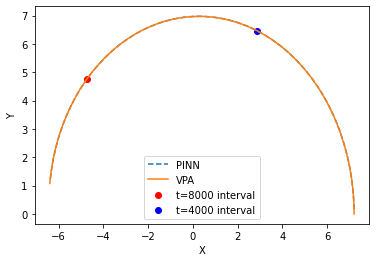

In [47]:


plt.plot(x_coordinates, y_coordinates, linestyle='--', label='PINN')
plt.plot(x_real_plt, y_real_plt, label='VPA')

# 标识 target_x0 和 target_x2 的点
plt.scatter(target_x0.numpy(), target_y0.numpy(), color='red', marker='o', label='t=8000 interval')
plt.scatter(target_x2.numpy(), target_y2.numpy(), color='blue', marker='o', label='t=4000 interval')

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
# plt.title('PINN neural network VS classic calculation')
plt.show()


In [39]:
file_lists = [x_coordinates, y_coordinates, z_coordinates]
file_names = ['hh_outputx.txt', 'hh_outputy.txt', 'hh_outputz.txt']

for file_list, old_name in zip(file_lists, file_names):
    new_name = new_prefix + old_name[2:]  # 保留原始文件名中的后缀部分
    with open(new_name, 'w') as f:
        for item in file_list:
            f.write("%s\n" % item)


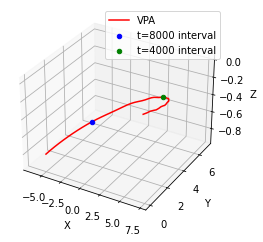

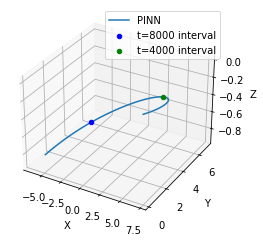

In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 绘制 classic computation 的轨迹
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_plt[::int(n_all/50)], y_plt[::int(n_all/50)], z_plt[::int(n_all/50)], color='red', label='VPA')

# 标识 target_x0 和 target_x2 的点
ax.scatter(target_x0.numpy(), target_y0.numpy(), target_z0.numpy(), color='blue', label='t=8000 interval')
ax.scatter(target_x2.numpy(), target_y2.numpy(), target_z2.numpy(), color='green', label='t=4000 interval')

ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_title('Particle Motion in Electromagnetic Field (Classic Computation)')
plt.show()

# 绘制 neural network 的轨迹
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_coordinates[::int(n_all/50)], y_coordinates[::int(n_all/50)], z_coordinates[::int(n_all/50)], label='PINN')

# 标识 target_x0 和 target_x2 的点
ax.scatter(target_x0.numpy(), target_y0.numpy(), target_z0.numpy(), color='blue', label='t=8000 interval')
ax.scatter(target_x2.numpy(), target_y2.numpy(), target_z2.numpy(), color='green', label='t=4000 interval')

ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_title('Particle Motion in Electromagnetic Field (Neural Network)')
plt.show()


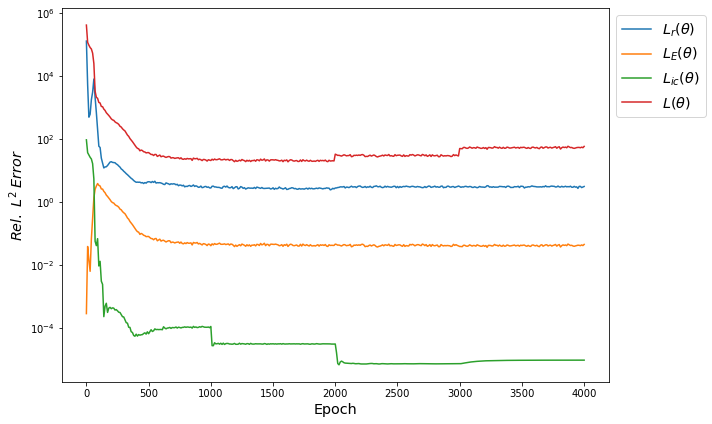

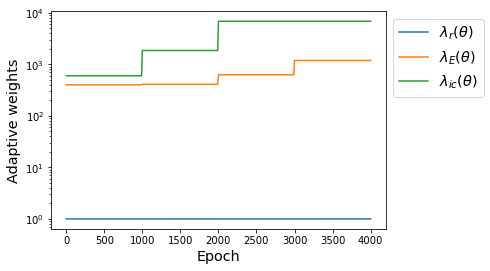

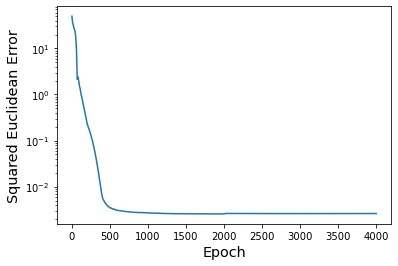

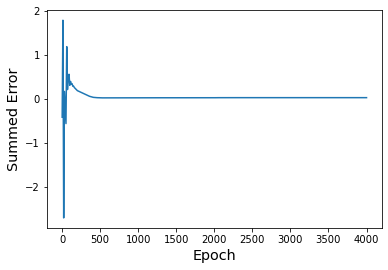

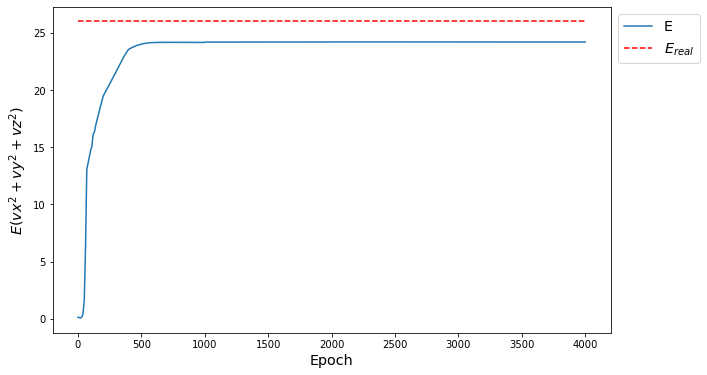

In [48]:
#绘制各loss成分随训练次数epoch变化图
epoch_total = len(loss_list)
epoch_array = np.array(range(0, epoch_total * n_epoch, n_epoch))

plt.figure(figsize=(10, 6))  # 设置图像大小为原始大小的1.3倍，10英寸6英寸
plt.plot(epoch_array,lpde_list,label=r'$L_{r}(\theta)$')
#plt.plot(epoch_array,lmiu_list, label='Loss of μ ')
plt.plot(epoch_array,lE_list, label=r'$L_{E}(\theta)$')
plt.plot(epoch_array,l0_list, label=r'$L_{ic}(\theta)$')
plt.plot(epoch_array,loss_list, label=r'$L(\theta)$')
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel(r'$Rel.\;L^2\;Error$', fontsize='x-large')
# plt.title(r'$Convergence\;of\;rel.\;L^2\;error\;during\;training\;process$')
# 添加图例并设置字体大小，并将其放在图形外部
plt.legend(fontsize='x-large', loc='upper left', bbox_to_anchor=(1, 1))


plt.tight_layout()# 自动调整布局，确保图像完整显示
plt.show()


plt.plot(epoch_array,lamda1_list,label=r'$λ_{r}(\theta)$')
plt.plot(epoch_array,lamda2_list,label=r'$λ_{E}(\theta)$')
plt.plot(epoch_array,lamda3_list,label=r'$λ_{ic}(\theta)$')
#plt.plot(epoch_array,lamda4_list,label='λ for loss of μ')
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel('Adaptive weights', fontsize='x-large')
# plt.title('Adaptive weights during training process')
plt.legend(fontsize='x-large', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()#绘图

plt.plot(epoch_array,loss_test_list)
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel('Squared Euclidean Error', fontsize='x-large')
# plt.title('Geometric difference of position from classic data during training process')


plt.show()  # 绘图


plt.plot(epoch_array,lossmean_test_list)
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel('Summed Error', fontsize='x-large')

plt.show()#绘图

# 绘制曲线
plt.figure(figsize=(10, 6))  # 设置图像大小为原始大小的1.3倍，10英寸6英寸
plt.plot(epoch_array, E_list, label='E')
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel(r'$E(vx^2+vy^2+vz^2)$', fontsize='x-large')
# plt.title('Kinetic energy (sum of squared velocities) during training process')
# 绘制直虚线
plt.hlines(y=26, xmin=epoch_array[0], xmax=epoch_array[-1], colors='r', linestyles='dashed', label=r'$E_{real}$')
plt.legend(fontsize='x-large', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()  # 绘图

In [42]:
#绘制损失函数在各时刻的分布
lpde_tl_list=[]

lE_tl_list=[]

loss_test_tl_list=[]

lossmean_test_tl_list=[]
for i in range(jump,(n_all+1+jump),10):
    t_tl = torch.tensor([i*interval]).view(-1, 1).requires_grad_(True)#tl:trainloss
    x_tl = u(t_tl)[:,0]
    y_tl = u(t_tl)[:,1]
    z_tl = u(t_tl)[:,2]
    vx_tl = gradients(x_tl, t_tl, 1)
    vy_tl = gradients(y_tl, t_tl, 1)
    vz_tl = gradients(z_tl, t_tl, 1)
    lpde1_tl = loss(gradients(vx_tl, t_tl, 1), q_over_m*(Ex + vy_tl * Bz(x_tl,y_tl,z_tl) - vz_tl * By(x_tl,y_tl,z_tl)))
    lpde2_tl = loss(gradients(vy_tl, t_tl, 1), q_over_m*(Ey + vz_tl * Bx(x_tl,y_tl,z_tl) - vx_tl * Bz(x_tl,y_tl,z_tl)))
    lpde3_tl = loss(gradients(vz_tl, t_tl, 1), q_over_m*(Ez + vx_tl * By(x_tl,y_tl,z_tl) - vy_tl * Bx(x_tl,y_tl,z_tl)))
    lE_tl = loss((vx_tl**2+vy_tl**2+vz_tl**2)**0.5,tensortarget)
    lpde_tl = lpde1_tl + lpde2_tl + lpde3_tl
    x_real_tl = x_real_plt[i-jump]
    y_real_tl = y_real_plt[i-jump]
    z_real_tl = z_real_plt[i-jump]
   
    loss_test_tl = loss(x_tl,x_real_tl)+loss(y_tl,y_real_tl)+loss(z_tl,z_real_tl)
    lossmean_test_tl = (x_tl-x_real_tl+y_tl-y_real_tl+z_tl-z_real_tl)
    lpde_tl_list.append(lpde_tl.item())
    lE_tl_list.append(lE_tl.item())
    loss_test_tl_list.append(loss_test_tl.item())
    lossmean_test_tl_list.append(lossmean_test_tl.item())
tl_array = np.arange(jump*interval, (n_all+1+jump)*interval, 10*interval)




C:\Users\hxm\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


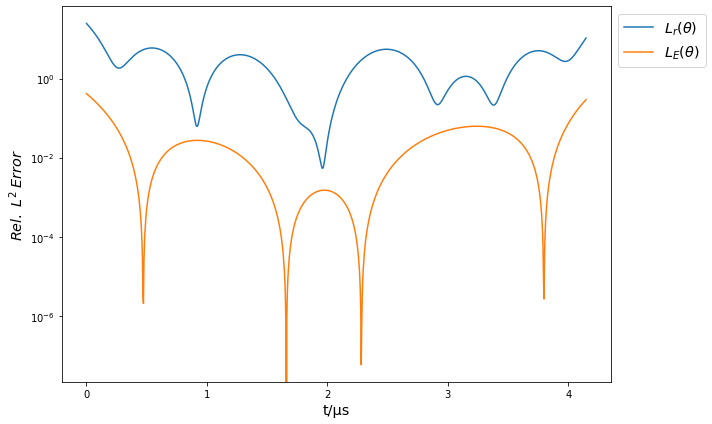

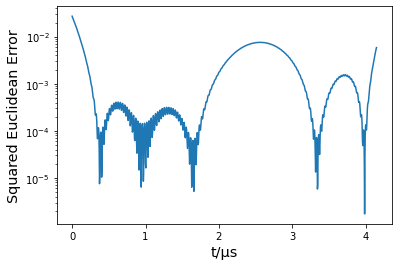

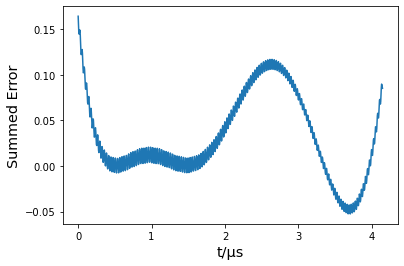

In [43]:
plt.figure(figsize=(10, 6))  # 设置图像大小为原始大小的1.3倍，10英寸6英寸
plt.plot(tl_array,lpde_tl_list,label=r'$L_{r}(\theta)$')
plt.plot(tl_array,lE_tl_list,label=r'$L_{E}(\theta)$')
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('t/μs', fontsize='x-large')
plt.ylabel(r'$Rel.\;L^2\;Error$', fontsize='x-large')
# plt.title('Loss of ODEs and loss of E from real data during motion process')
plt.legend(fontsize='x-large', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()# 自动调整布局，确保图像完整显示
plt.show()

plt.plot(tl_array,loss_test_tl_list)
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('t/μs', fontsize='x-large')
plt.ylabel('Squared Euclidean Error', fontsize='x-large')
# plt.title('Geometric differences of position from real data during motion process')

plt.show()#绘图

plt.plot(tl_array,lossmean_test_tl_list)
plt.xlabel('t/μs', fontsize='x-large')
plt.ylabel('Summed Error', fontsize='x-large')
# plt.title('Arithmetic differences of position from real data during motion process')

plt.show()#绘图

In [44]:
file_lists = [lpde_tl_list,  lE_tl_list,  loss_test_tl_list, lossmean_test_tl_list]
file_names = ['hh_lpde_tl_list.txt', 'hh_lE_tl_list.txt',  'hh_loss_test_tl_list.txt', 'hh_lossmean_test_tl_list.txt']

for file_list, old_name in zip(file_lists, file_names):
    new_name = new_prefix + old_name[2:]  # 保留原始文件名中的后缀部分
    with open(new_name, 'w') as f:
        for item in file_list:
            f.write("%s\n" % item)
